## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.EnsembleTwo import *

In [2]:
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(809)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [5]:
size = 44
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [6]:
root = 'df_224/train'
train_data = create_dataset(root, transformation)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler=sampler)

In [7]:
root = 'df_224/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'df_224/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[54921, 45909, 15063, 26486, 50205, 59206, 16911, 54962, 43174]


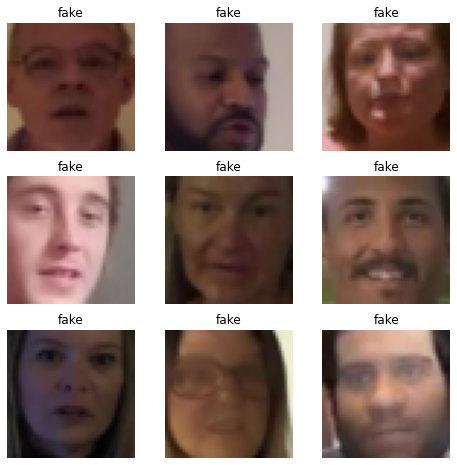

In [9]:
visualize_data(train_data)

[142, 9132, 7358, 7099, 5023, 2223, 5483, 4832, 7568]


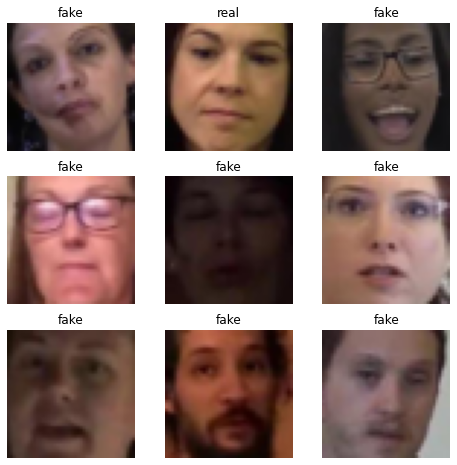

In [66]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 3

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
model.load_state_dict(torch.load("./DeepSearch2_15epochs")["model_state_dict"])
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=9216, out_features=512, bias=True)
      (batch_norm): BatchNo

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr=0.01)
optimizer.load_state_dict(torch.load("./DeepSearch2_15epochs")["optimizer_state_dict"])

In [67]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 1)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.671875
Epoch 1/1, Batch number: 5, Cumulated accuracy: 0.7122395833333334
Epoch 1/1, Batch number: 10, Cumulated accuracy: 0.7063210227272727
Epoch 1/1, Batch number: 15, Cumulated accuracy: 0.703857421875
Epoch 1/1, Batch number: 20, Cumulated accuracy: 0.7085193452380952
Epoch 1/1, Batch number: 25, Cumulated accuracy: 0.70703125
Epoch 1/1, Batch number: 30, Cumulated accuracy: 0.7074092741935484
Epoch 1/1, Batch number: 35, Cumulated accuracy: 0.7068142361111112
Epoch 1/1, Batch number: 40, Cumulated accuracy: 0.7069359756097561
Epoch 1/1, Batch number: 45, Cumulated accuracy: 0.7086447010869565
Epoch 1/1, Batch number: 50, Cumulated accuracy: 0.710171568627451
Epoch 1/1, Batch number: 55, Cumulated accuracy: 0.71240234375
Epoch 1/1, Batch number: 60, Cumulated accuracy: 0.713563012295082
Epoch 1/1, Batch number: 65, Cumulated accuracy: 0.7117660984848485
Epoch 1/1, Batch number: 70, Cumulated accuracy: 0.7125330105633803
Epoch 1/1, 

## Testing Model & Performance Curves

In [68]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.5010, Test accuracy: 0.7444


Precision: 0.37488486337120047
Recall: 0.7495395948434622
F1 score: 0.49979533360622175


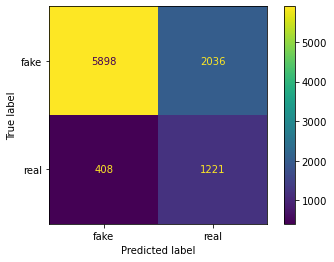

In [69]:
show_metrics(true_labels, model_preds)

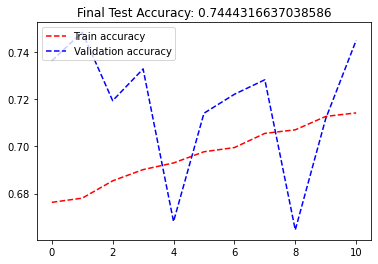

In [70]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

In [74]:
print(train_accuracies)

[0.6762560777957861, 0.678033669681602, 0.6853923772677367, 0.6901631201965808, 0.6929863543681707, 0.6977440267684425, 0.6995216186542583, 0.7055471323260313, 0.7070633136404036, 0.7127489935693, 0.7142521043551001]


In [75]:
print(val_accuracies)

[0.7363797971347903, 0.7485098818362439, 0.7194395064310363, 0.7329289971766182, 0.6680957858412632, 0.7141064519502248, 0.7221583185192931, 0.7283279305657221, 0.6645404161873889, 0.7118059186447767, 0.7450590818780717]


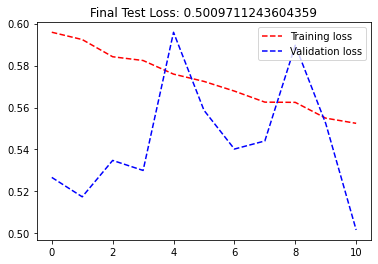

In [71]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [76]:
print(train_losses)

[0.5958704539764685, 0.5923885617367799, 0.5841903311751758, 0.582401006417131, 0.5759165241168096, 0.5724374085764422, 0.5678244840141922, 0.562560654304498, 0.562457019768431, 0.5549269104282991, 0.552463824035332]


In [77]:
print(val_losses)

[0.5266908603279215, 0.5174434867344404, 0.5347844158348284, 0.5300105880749854, 0.5958434453136042, 0.5586770208258378, 0.5401998248539472, 0.5440629226596732, 0.5896677319940767, 0.5524137725955561, 0.5016679238331946]


## Old curves, forgot to save values

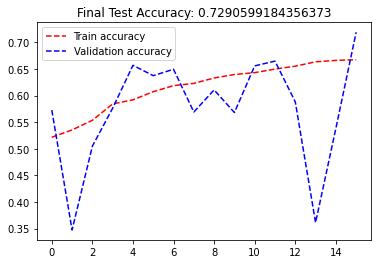

In [88]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

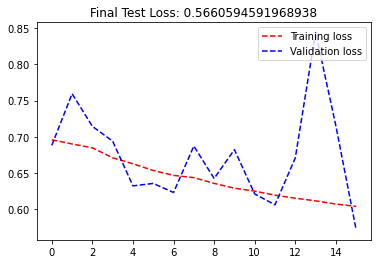

In [89]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [ ]:
test_loader2 = produce_loader(test_data, 1)

In [ ]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

In [ ]:
show_metrics(true_labels2, model_preds2)

In [ ]:
visualize_data(correct_list, (12,12), 5)

In [ ]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [90]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch2_15epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])